# Predicting Customers in Different Parts of Helsinki using Deep Learning by Daniel Wohlrath

### Question: Based on weather forecast, in which part of Helsinki are we going to receive orders from in a specific day and hour?

### Answer: See in this notebook

Understanding the customers' needs is of paramount desire in every type of customer-based business. Predicting the flow of orders can help Wolt be one step ahead and plan accordingly to the demand. __Knowing the number of orders__ in different scenarios can help us answer the following:

- In what parts of Helsinki is there need for couriers?
- Should we focus on closing partnerships with restaurants in specific areas?
- Are there specific times where the demand for our services is higher/lower?

The above questions naturally suggest some features to be used in the prediction task:
- location,
- weather,
- time.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb

from preprocessing import preprocessing,plot_average_week,check_unique, add_padding, count_orders,plot_test_loss
from preprocessing import augment_ohe_clusters, get_test_pred_df, plot_test_prediction, plot_test_scatter

/tmp/ipykernel_202892/3939700593.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-10 14:21:49.169187: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 14:21:49.478569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 14:21:49.478668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugi

## Exploration

- features augmentation, i.e. deriving features from the original raw data,
- scaling.

We work further with ```data```.

In [2]:
filepath = 'orders_autumn_2020.csv'
data = preprocessing(filepath)

### Handling missing data

Missing data occur exclusively on 10th of September 2020. This day does not have any special significance (e.g., a holiday, a major event, or extreme weather conditions). It was probably just an error in data collection.

In addition, the proportion of missing data is so small, that it is very beneficial to treat missing data as a random error of data collection and avoid added computational burden that would be needed by analysis of why the data is missing. Under the assumption that it is a random error, we can delete the corresponding rows and perform ```complete-case analysis```. This __does not bias__ the inference.

Another possible approach would be try to model the missing data based on the observed data. Easy-to-implement methods are for example
- mean imputation, 
- regression imputation or 
- stochastic regression imputation
unfortunately, these introduce bias to the downstream analysis. 

A method that would be the most appropriate is multiple imputation, but this is very computationally heavy.

In [3]:
data_notmissing = data.copy().dropna()
data_missing = data.copy()[data.isna().any(axis=1)]

In [4]:
# Checks: Is there any other data missing than on 10th of September? 
print("Print shape of data from 9/10, that is fully observed:",data_notmissing[data_notmissing['TIMESTAMP'].dt.date == pd.to_datetime('2020-09-10').date()].shape)
# Shows what data has missing values for weather 
print("Print all data that is missing on 9/10",data_missing[data_missing['TIMESTAMP'].dt.date == pd.to_datetime('2020-09-10').date()])
data=data.dropna().reset_index(drop=True)

Print shape of data from 9/10, that is fully observed: (0, 26)
Print all data that is missing on 9/10                 TIMESTAMP  \
11778 2020-09-10 06:22:00   
11779 2020-09-10 06:29:00   
11780 2020-09-10 06:31:00   
11781 2020-09-10 06:38:00   
11782 2020-09-10 07:00:00   
...                   ...   
12050 2020-09-10 18:56:00   
12051 2020-09-10 19:07:00   
12052 2020-09-10 19:09:00   
12053 2020-09-10 19:43:00   
12054 2020-09-10 19:55:00   

       ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  ITEM_COUNT  \
11778                                                 -1              2   
11779                                                  4              1   
11780                                                  1              2   
11781                                                 -7              2   
11782                                                  7              2   
...                                                  ...            ...   
12050                   

### Encoding location into clusters

We choose to encode the location information as __affiliation of the venue__ to one of $4$ clusters. These clusters are found using ```K-Means``` algorithm on MinMax scaled user location data. This is because the user data are evenly spread across the whole Helsinki area, which enables us to find meaningful regions. The result is following a structure that can be described using combinations of North-South-West-East.

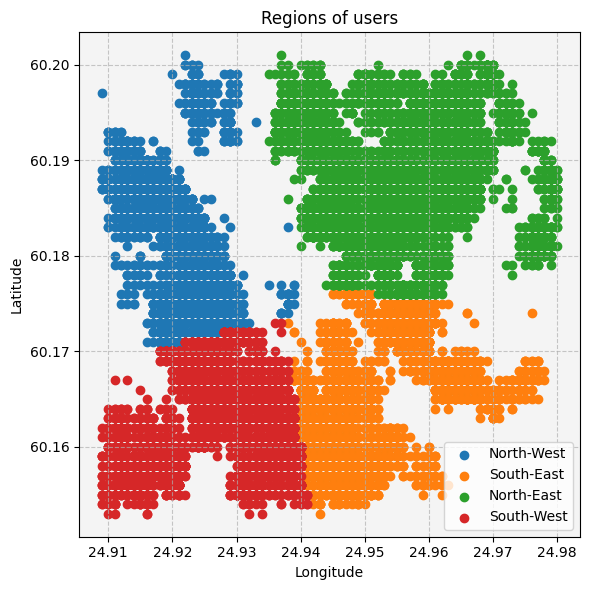

In [5]:
"""
__N.B.!__
the variable ```cluster_names``` is manually set to be accurate
with all the initial settings the way they are at the time 
of finishing to project. Any tampering with randomness (e.g. set seed of numpy)
would result into incorrect names for clusters (switching north-south and so on).
"""
num_clusters = 4
# Use KMeans to cluster coordinates, using USER values because they have more variance than venues
kmeans = KMeans(n_clusters=num_clusters, random_state=1,n_init=20).fit(data[['USER_LONG_scaled','USER_LAT_scaled']].values)
data['user_cluster'] = kmeans.labels_
data['venue_cluster'] = kmeans.predict(data[['VENUE_LONG_scaled','VENUE_LAT_scaled']].values)
clusters = np.sort(data['user_cluster'].unique())
# This variable is only created for nicer figures
cluster_names= ['North-West','South-East','North-East','South-West']
# Create a scatter plot for each cluster with a distinct color
plt.figure(figsize=(6, 6))
for i,cluster in enumerate(clusters):
    cluster_data = data[data['user_cluster'] == cluster]
    plt.scatter(cluster_data['USER_LONG'], cluster_data['USER_LAT'], label=f'{cluster_names[i]}', marker='o')

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Regions of users')
x_limits = plt.xlim()
y_limits = plt.ylim()

plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('#f4f4f4')  # Light gray background
# Show the legend
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

## Encoding time features



Except for __day of the year__, we will also use the __hour__ during the day and __day of the week__ as features. The following graphs show the differences in number of orders throughout the days, and for different days of the week.

Hourly counts of orders show that there are two peaks in the overall data, one around 12 and one around 18. These stamps are probably explained by lunch and dinner time. So modeling the number of orders during the day, we want to see the same bimodal shape in our prediction model.

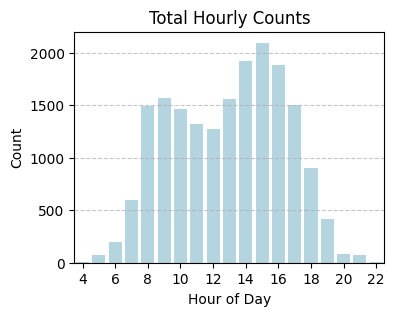

In [6]:
hour_counts = data.groupby('hour')['weekday'].count()

# Assuming 'hour_counts' is your Series with hour-wise counts
plt.figure(figsize=(4, 3))
sns.barplot(x=hour_counts.index, y=hour_counts.values, color='lightblue')

plt.title('Total Hourly Counts')
plt.xlabel('Hour of Day')
# create x ticks every 2 hours
plt.xticks(np.arange(0, 20, 2))

plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Investigation of weekdays feature

Daily counts of orders (plot below) show that there are __more orders on weekends than on weekdays__. In addition, the shape of distribution of orders on weekends is not as clearly bimodal as during the weekdays (workdays). This __supports our modeling idea__ of using different days of the week as features, as (for example) the flow of orders during the weekends is different to the one during weekdays.

In [7]:
data_over_days = data[['weekday','hour','user_cluster']]
# Step 1: Create a complete MultiIndex for all combinations
all_weekdays = range(7)  # Weekday from 0 to 6
all_hours = range(24)    # Hour from 0 to 23
all_clusters = range(4)  # Assuming user_cluster ranges from 0 to 3
all_weeks = range(10) # week from 0 to 9

multi_index = pd.MultiIndex.from_product([all_weekdays, all_hours, all_clusters], 
                                         names=['weekday', 'hour', 'user_cluster'])

# Step 2: Group and aggregate your data
grouped_data = data_over_days.groupby(['weekday', 'hour', 'user_cluster']).size()
grouped_data = grouped_data.reset_index(name='orders')

# Step 3: Reindex with the complete MultiIndex
padded_data = grouped_data.set_index(['weekday', 'hour', 'user_cluster']).reindex(multi_index, fill_value=0).reset_index()


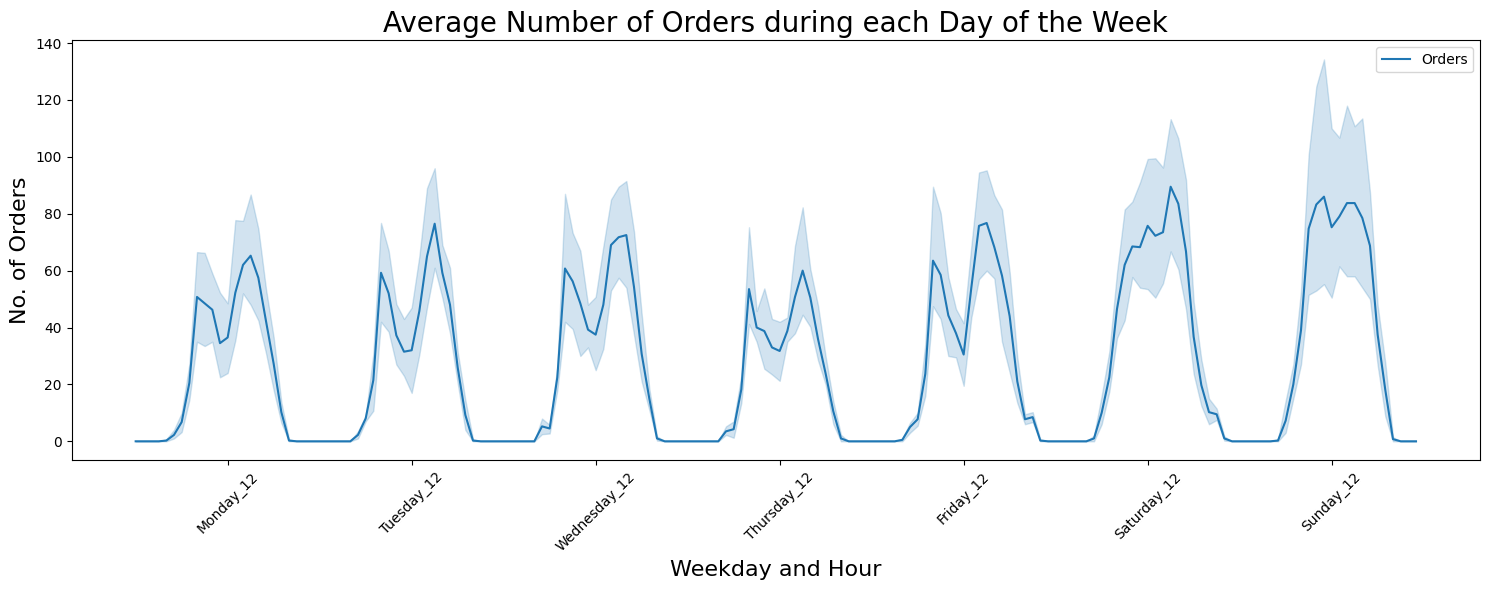

In [8]:
plot_average_week(padded_data)

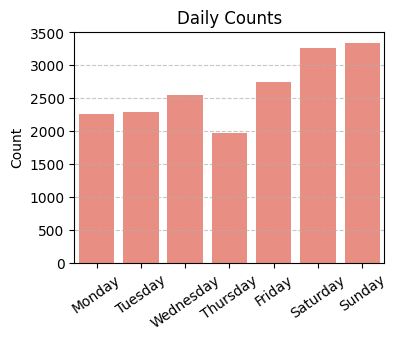

In [9]:
weekday_counts = data.groupby('weekday')['hour'].count()
weekday_counts.index = weekday_counts.index.rename('weekday').map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Assuming 'weekday_counts' is your Series with hour-wise counts
plt.figure(figsize=(4, 3))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, color='salmon')

plt.xlabel('')
plt.title('Daily Counts')
plt.xticks(rotation=35, ha='center')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Investigation of weather features

As seen from the histograms below, ```TEMPERATURE, WIND_SPEED``` are more evenly distributed in range of their values than ```PRECIPITATION, CLOUD_COVERAGE```. The latter have mostly value $0$ and occasionally some other.

For better performance of our algorithms, we choose to scale the weather-related variables using ```sklearn.preprocessing.MinMaxScaler``` into the [0,1] range.

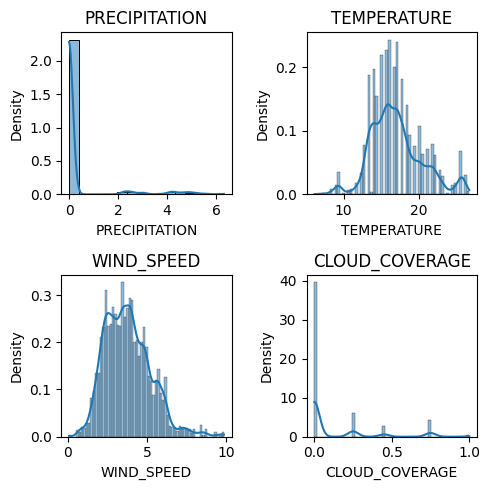

In [10]:
weather = data[['PRECIPITATION','TEMPERATURE','WIND_SPEED','CLOUD_COVERAGE']]
#Creating 2x2 subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotting histograms for each column
for i, column in enumerate(weather.keys()):
    sns.histplot(weather[column],stat='density', ax=axes[i], kde=True)
    axes[i].set_title(column)
    axes[i].set_ylabel('Density')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Investigation of location features

__1-way and 2-way marginal counts of users and venues__:

The counts of venues and users in each cluster are shown below. The clusters found by K-Means are reasonable and we can see that they are neither balanced in number of users nor venues. This justifies predicting the number of orders based on the cluster.

We also observe that people order mostly from restaurants in South-Western Helsinki. Most users are in the Nort-East.

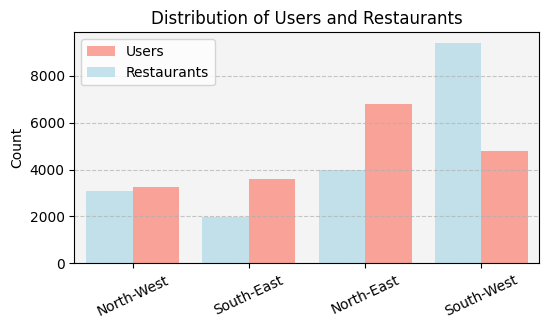

In [11]:
MQ_data = data[['user_cluster','venue_cluster']]
#Count occurrences of each value in both columns
user_counts = MQ_data['user_cluster'].value_counts().sort_index()
venue_counts = MQ_data['venue_cluster'].value_counts().sort_index()

user_counts.index = user_counts.index.rename('user_cluster').map({0: cluster_names[0], 1: cluster_names[1], 2: cluster_names[2], 3: cluster_names[3]})
venue_counts.index = venue_counts.index.rename('venue_cluster').map({0: cluster_names[0], 1: cluster_names[1], 2: cluster_names[2], 3: cluster_names[3]})

# Create a bar plot with grouped bars
fig, ax = plt.subplots(figsize=(6, 3))

# Plot user clusters with salmon bars
user_counts.plot(kind='bar', color='salmon', alpha=0.7, position=0, width=0.4, label='Users', ax=ax)

# Plot venue clusters with light blue bars
venue_counts.plot(kind='bar', color='lightblue', alpha=0.7, position=1, width=0.4, label='Restaurants', ax=ax)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a background color for better visibility
ax.set_facecolor('#f4f4f4')  # Light gray background

# Set labels and title
ax.set_xlabel('')
ax.set_ylabel('Count')
plt.xticks(rotation=25, ha='center')
ax.set_title('Distribution of Users and Restaurants')
ax.set_xlim(left=-0.5, right=len(user_counts) - 0.5)

# Add legend
ax.legend()

# Show the plot
plt.show()

The cross-tabulation shows where __users from different clusters order from__. This can be used in further analysis to determine if Wolt should make partnership with more restaurants in an area, where there is a lot of users but not enough restaurants. 

For example, users from South-West order a lot from North-West, more than __5 times more__ than from their own area. This indicates that there is a possibility to co-operate with more restaurants from South-West.

Text(0.5, 1.0, 'User and Restaurant Cross-Tabulation')

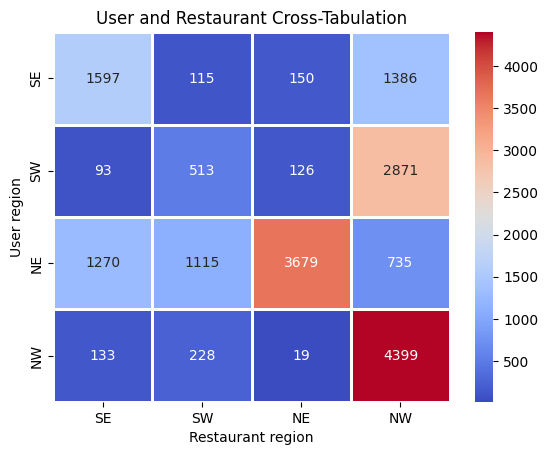

In [12]:
# Create a cross-tabulation of user_cluster and venue_cluster
cross_tab = pd.crosstab(MQ_data['user_cluster'], MQ_data['venue_cluster'])
#cross_tab.index = cross_tab.index.rename('venue_cluster').map({0: cluster_names[0], 1: cluster_names[1], 2: cluster_names[2], 3: cluster_names[3]})
cross_tab.index = cross_tab.index.rename('user_cluster').map({0: 'SE', 1: 'SW', 2: 'NE', 3: 'NW'})
cross_tab.columns = cross_tab.columns.rename('venue_cluster').map({0: 'SE', 1: 'SW', 2: 'NE', 3: 'NW'})


sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt='d', linewidths=1,
            annot_kws={'size':10})
plt.xlabel('Restaurant region')
plt.ylabel('User region')
plt.title('User and Restaurant Cross-Tabulation')


### Corellation between features

We show how the used features correlate with each other. The location of the user and time data appear to be uncorrelated with other features. On the other hand, we can see some reasonable correlation in the weather data.

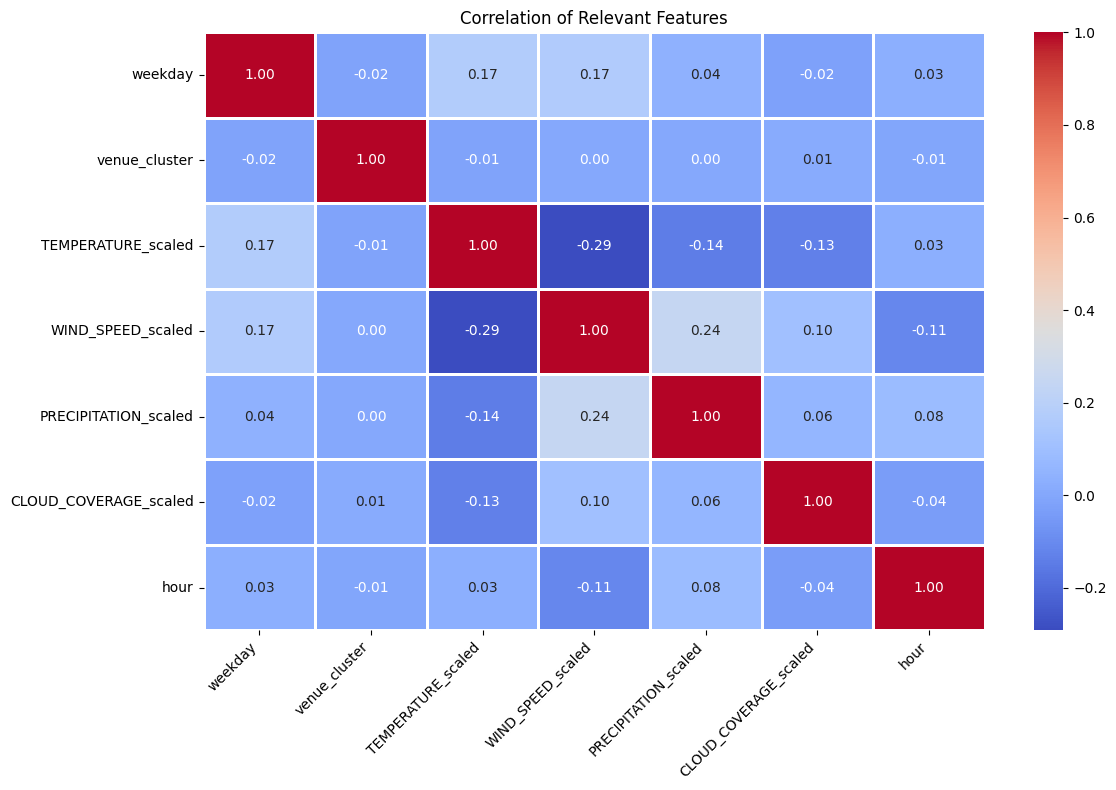

In [13]:
# Taking relevant features
features = ['weekday','venue_cluster','TEMPERATURE_scaled','WIND_SPEED_scaled',
                           'PRECIPITATION_scaled','CLOUD_COVERAGE_scaled','hour']
# Assuming data is your DataFrame
correlation_matrix = data[features].corr()

# Plotting the heatmap with rotated axis labels
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=1, annot_kws={"size": 10})  # Adjust linewidths and annot_kws as needed

# Rotating axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust fontsize as needed
plt.yticks(rotation=0, ha='right', fontsize=10)  # Adjust fontsize as needed

# Setting title
plt.title('Correlation of Relevant Features')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Visualization of users and venues

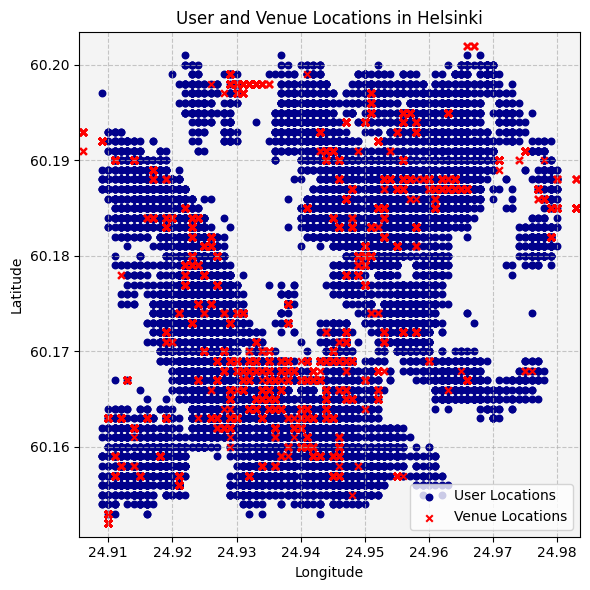

In [14]:
plt.figure(figsize=(6, 6))
# Create a scatter plot for User Locations
plt.scatter(data['USER_LONG'], data['USER_LAT'], s=22,color='darkblue', label='User Locations')

# Create a scatter plot for Venue Locations
plt.scatter(data['VENUE_LONG'], data['VENUE_LAT'], s=22, color='red', label='Venue Locations', marker='x')

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('User and Venue Locations in Helsinki')

plt.xlim(x_limits)
plt.ylim(y_limits)
# Add legend
plt.legend()

plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.gca().set_facecolor('#f4f4f4')  # Light gray background

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()

### Map of helsinki with users

In [17]:
# Helsinki coordinates
helsinki_coords = [60.1699, 24.9384]
helsinki_map = folium.Map(location=helsinki_coords, zoom_start=13)

# Create a MarkerCluster layer for the plot points
marker_cluster = MarkerCluster().add_to(helsinki_map)

# Add each point to the MarkerCluster layer
for lat, lon in zip(data['USER_LAT'], data['USER_LONG']):
    folium.Marker(location=[lat, lon]).add_to(marker_cluster)

# Save the map to an HTML file
helsinki_map.save('helsinki_map_users.html')

# Another map
# map = folium.Map(location=helsinki_coords,zoom_start=12)
# for lat_lon in zip(data['USER_LAT'],data['USER_LONG']):
#     folium.CircleMarker(lat_lon,radius=2,color='darkblue',fill=True,fill_color='darkblue').add_to(map)

# for lat_lon in zip(data['VENUE_LAT'],data['VENUE_LONG']):
#     folium.CircleMarker(lat_lon,radius=2,color='red',fill=True,fill_color='red').add_to(map)
# map.save('map.html')

# Modeling

We are interested in predicting the number of incoming orders during the day based on ```location```, ```type of the day``` and ```weather```.

It is evident from the exploratory data analysis, that number of orders is dependent on location of restaurants and which part of the week it is. It is very natural to also __include weather as a predictor__, even though we need to note that (especially) the weather data is biased, as we have only datapoints from summer.

We could naively think that people order the most when there is good weather, since it is sunny most of the time in summer. But we cannot make a valuable inference if we do not know how often the weather is good (no rain, clear sky, etc.). To make such educated inference, we would need to have access to full weather data.

In [106]:
features = ['dayofyear','weekday',
 'venue_cluster',
 'TEMPERATURE_scaled',
 'WIND_SPEED_scaled',
 'PRECIPITATION_scaled',
 'CLOUD_COVERAGE_scaled',
 'hour']
final_data = data[features].copy()

In [107]:
# Here we check that weather is in fact being updated every 1 hour,
# So we can create variable 'orders' that stores the number of orders
# for each hour, cluster and weather conditions
check_weather_update = final_data.groupby(['hour', 'dayofyear'])[['CLOUD_COVERAGE_scaled', 'TEMPERATURE_scaled', 'WIND_SPEED_scaled', 'PRECIPITATION_scaled']].nunique()
check_unique(check_weather_update)

### Train-validation-test split

We use the following terminology:
- Train data: the model is being trained on
- Validation data: to check for overfitting during training
- Test data: to evaluate final performance of the trained model

In total, there is records from 60 days. We use the very last 7 days as test set (11.66%) and as validation set 5 consecutive days (8.33%) before the start of test set.

In [108]:
# Randomly choose a start day for the M-day test set
M_test = 7
M_val = 5
test_start_day, test_end_day = final_data['dayofyear'].max() - (M_test-1), final_data['dayofyear'].max()
val_start_day, val_end_day = test_start_day - M_val, test_start_day - 1
# Choose 5 random, non-consecutive days for validation set
all_days = set(final_data['dayofyear'].unique())
test_days = set(range(test_start_day, test_end_day + 1))
val_days = set(range(val_start_day, val_end_day + 1))
# Step 2: Split the Data
test_set = final_data[final_data['dayofyear'].between(test_start_day, test_end_day)]
val_set = final_data[final_data['dayofyear'].between(val_start_day,val_end_day)]
train_set = final_data[~final_data['dayofyear'].isin(test_days.union(set(val_days)))]

# Checking the size of each set
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 14438
Validation set size: 1684
Test set size: 2307


In [109]:
# Add 'orders' column
test_set = count_orders(test_set)
val_set = count_orders(val_set)
train_set = count_orders(train_set)

In [110]:
X_train = train_set.drop(['orders'],axis=1)
y_train = train_set['orders']
X_val = val_set.drop(['orders'],axis=1)
y_val = val_set['orders']
X_test = test_set.drop(['orders'],axis=1)
y_test = test_set['orders']

In [111]:
# Augment one-hot encoding of clusters
X_train_ohe = augment_ohe_clusters(X_train)
X_val_ohe = augment_ohe_clusters(X_val)
X_test_ohe = augment_ohe_clusters(X_test)

In [112]:
# Scaling data for better NN performance
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)
X_val_scaled = scaler.transform(X_val_ohe)

## Vanilla Multi-Layer Perceptron

MLP with 4 hidden layers, ReLU activation function and 20% of Dropout. We use ```mean squared error``` as a loss function. It is widely used as a robust option. This choice penalizes outliers a lot.

Epoch 1/100
80/80 [==============================] - 2s 8ms/step - loss: 21.6031 - val_loss: 19.5007
Epoch 2/100
80/80 [==============================] - 0s 5ms/step - loss: 14.8292 - val_loss: 21.8912
Epoch 3/100
80/80 [==============================] - 0s 6ms/step - loss: 13.0844 - val_loss: 18.3699
Epoch 4/100
80/80 [==============================] - 0s 5ms/step - loss: 11.9979 - val_loss: 24.0935
Epoch 5/100
80/80 [==============================] - 0s 6ms/step - loss: 11.7116 - val_loss: 23.3495
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 11.1802 - val_loss: 21.3331
Epoch 7/100
80/80 [==============================] - 0s 6ms/step - loss: 10.5093 - val_loss: 21.7832
Epoch 8/100
80/80 [==============================] - 0s 6ms/step - loss: 9.6763 - val_loss: 18.6380
Epoch 9/100
80/80 [==============================] - 0s 5ms/step - loss: 9.5714 - val_loss: 18.7518
Epoch 10/100
80/80 [==============================] - 0s 6ms/step - loss: 9.3334 - val_loss: 

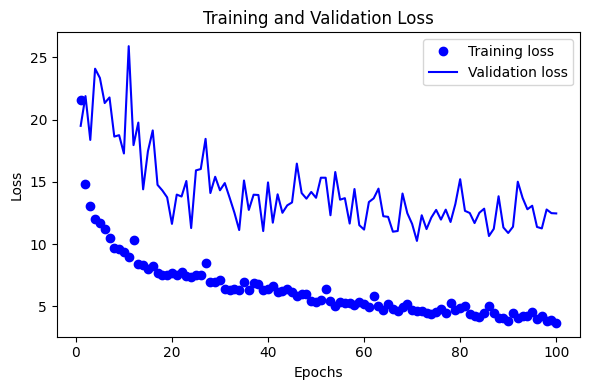

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8

In [25]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1) 
])

mlp_model.compile(optimizer='adam', loss='mean_squared_error')
history = mlp_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1)

# Evaluate the mlp_model on the test set
test_loss = mlp_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test: {test_loss}")
plot_test_loss(history)
mlp_model.summary()


## BiDirectional Long-Short-Term-Memory Recurrent Neural Network

We use LSTM because it is a good model for time series data. We use the same data and loss function as in the MLP model, we just need to reshape it appropriately.

In [128]:
# define sequences for LSTM, set sequence_length to the number of previous observations you want to take into account when predicting next value
def create_sequences(data, targets, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length + 1):  # Adjust to not lose the last data point
        x = data[i:(i + sequence_length), :]
        xs.append(x)
        if targets is not None:
            ys.append(targets[i + sequence_length - 1])  # Assuming targets are aligned and we predict the next value
    return np.array(xs), np.array(ys)

# Example usage:
sequence_length = 10
X_RNN_train_scaled, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
X_RNN_test_scaled, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)
X_RNN_val_scaled, y_val_seq = create_sequences(X_val_scaled, y_val, sequence_length)


Epoch 1/40
79/79 [==============================] - 60s 438ms/step - loss: 46.4707 - val_loss: 35.2411
Epoch 2/40
79/79 [==============================] - 32s 403ms/step - loss: 17.4916 - val_loss: 21.4179
Epoch 3/40
79/79 [==============================] - 34s 426ms/step - loss: 13.7719 - val_loss: 18.2505
Epoch 4/40
79/79 [==============================] - 35s 443ms/step - loss: 12.1763 - val_loss: 18.6078
Epoch 5/40
79/79 [==============================] - 30s 375ms/step - loss: 12.4064 - val_loss: 17.4213
Epoch 6/40
79/79 [==============================] - 30s 384ms/step - loss: 12.4936 - val_loss: 17.2043
Epoch 7/40
79/79 [==============================] - 28s 361ms/step - loss: 12.4589 - val_loss: 17.1293
Epoch 8/40
79/79 [==============================] - 27s 341ms/step - loss: 12.4773 - val_loss: 18.1704
Epoch 9/40
79/79 [==============================] - 28s 356ms/step - loss: 11.9719 - val_loss: 17.0334
Epoch 10/40
79/79 [==============================] - 28s 359ms/step - los

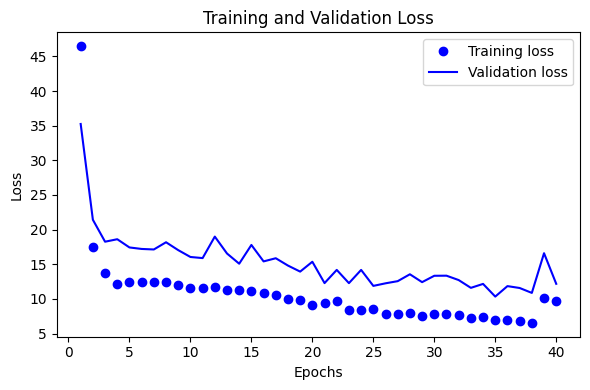

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_155 (Bidirec  (None, 10, 200)           89600     
 tional)                                                         
                                                                 
 bidirectional_156 (Bidirec  (None, 10, 400)           641600    
 tional)                                                         
                                                                 
 bidirectional_157 (Bidirec  (None, 10, 800)           2563200   
 tional)                                                         
                                                                 
 bidirectional_158 (Bidirec  (None, 10, 400)           1601600   
 tional)                                                         
                                                                 
 bidirectional_159 (Bidirec  (None, 10, 200)         

In [132]:
#X_RNN_train_scaled = np.array(X_train_scaled).reshape((X_train_scaled.shape[0], sequence_length, X_train_scaled.shape[sequence_length]))
#X_RNN_test_scaled = np.array(X_test_scaled).reshape((X_test_scaled.shape[0], sequence_length, X_test_scaled.shape[sequence_length]))
#X_RNN_val_scaled = np.array(X_val_scaled).reshape((X_val_scaled.shape[0], sequence_length, X_val_scaled.shape[sequence_length]))
# Define the RNN model
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu',return_sequences=True), input_shape=(sequence_length, X_RNN_train_scaled.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(400, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(75, activation='relu',return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu')),
    tf.keras.layers.Dense(1)
])


rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Make sure to use y_train_seq, y_test_seq, and y_val_seq for fitting and evaluation
history_rnn = rnn_model.fit(X_RNN_train_scaled, y_train_seq, epochs=40, batch_size=32, validation_data=(X_RNN_val_scaled, y_val_seq), verbose=1)

rnn_test_loss = rnn_model.evaluate(X_RNN_test_scaled, y_test_seq)
print(f"Test MSE: {rnn_test_loss}")
print(f"Test MSE: {rnn_test_loss}")
plot_test_loss(history_rnn)
rnn_model.summary()

## Random forest

We use the validation set as model selection tool for tuning the number of decision trees. The corresponding RF with lowest MSE on validation data is evaluated on test data.

In [27]:
# Creating Train-Validation split for GridSearchCV used in RF, KNN and XGB
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.concatenate((y_train, y_val))
split_index = [-1] * len(X_train_scaled) + [0] * len(X_val_scaled)
pds = PredefinedSplit(test_fold=split_index)

In [28]:
param_grid_rf = {
    'n_estimators': [25,50,100,200,400, 500, 1000, 5000],
    'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80],
}
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid_rf,
                           cv=pds,  # Number of cross-validation folds
                           scoring='neg_mean_squared_error')


# Fit grid search to the training data
grid_search_rf.fit(X_combined, y_combined)

# Best hyperparameters and corresponding MSE
print("Best hyperparameters:", grid_search_rf.best_params_)
print("Best MSE:", -grid_search_rf.best_score_)

rf_regressor = RandomForestRegressor(**grid_search_rf.best_params_, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Test MSE: {mse_rf}, mae: {mae_rf}")

Best hyperparameters: {'max_depth': 10, 'n_estimators': 5000}
Best MSE: 8.441447126739403
Test MSE: 7.116517428474452, mae: 1.9634775454543882


## K-Nearest Neighbours

In [29]:
# Parameters to test in the grid search
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10,13,15,17,20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [2,3,4,5,6,7,8,9,10],
    'p': [1, 2]
}

knn = KNeighborsRegressor()

# Grid search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=pds, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_combined, y_combined)

# Best parameters and best score
print("Best parameters:", grid_search_knn.best_params_)
print("Best score (MSE):", -grid_search_knn.best_score_)

best_knn = KNeighborsRegressor(**grid_search_knn.best_params_)
best_knn.fit(X_train_scaled, y_train)
y_pred_knn = best_knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print('Mean Squared Error:', mse_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print('Mean Absolute Error:', mae_knn)

Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best score (MSE): 13.32900880759439
Mean Squared Error: 11.064997830774779
Mean Absolute Error: 2.569998668113703


## XGBoost

In [30]:
# Define the parameter grid
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
    # Add other parameters here
}

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize Grid Search with the predefined split
grid_search_xgb = GridSearchCV(model, param_grid_xgb, cv=pds, scoring='neg_mean_squared_error')

# Fit Grid Search on the combined dataset
grid_search_xgb.fit(X_combined, y_combined)

# The best hyperparameters and corresponding MSE
print("Best parameters:", grid_search_xgb.best_params_)
print("Best MSE:", -grid_search_xgb.best_score_)

best_xgb = xgb.XGBRegressor(**grid_search_xgb.best_params_)
best_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = best_xgb.predict(X_test_scaled)
print('Test mse:',mean_squared_error(y_test, y_pred_xgb))
print('Test mae:',mean_absolute_error(y_test, y_pred_xgb))

Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Best MSE: 8.615761839156967
Test mse: 7.7398030292050874
Test mae: 2.0782277351245284


# Evaluation on test data
We show how well can predict our model the future (test data).


We __average data over different locations__ (clusters) and __weather conditions__. We show how the number of orders during the day change based on the weekday.

The figures below show predicted (__red__) and observed (__blue__) average number of orders during the day in an 'average' location of Helsinki with 'average' weather conditions throughout the test data week. The confidence intervals in the following figures are 95% confidence intervals of the mean created using bootstrapping.

There could be many different numbers of orders for the same hour, they correspond to different weather conditions and locations. We choose to show the mean and its 95% CI.

## Padding values in test data
For better visualization, we create continuous variable ```day_hour``` which has padding of unobserved values for hours, clusters and weather forecast. We want to have equidistant timesteps, i.e. every hour during the test week.

__For example__: We assume that if there is a record of an order from cluster $1$ at 9 AM on Tuesday, but no records of other clusters at this exact time, it means that there was 0 orders during that time. This is a reasonable assumption. In order to make our prediction models still work with the same settings, the weather forecast is imputed using backward and forward fill.

### N.B.

We could have used this approach on the original data but we cannot be sure about the effect of this tampering. It is always the best to keep the data realistic and do not create synthetic values anywhere. In this case, We do it just for better visualization of the test data.

In [31]:
padded_data = add_padding(test_set)[train_set.columns]

/home/wohldan/Desktop/submittedWolt/submittedWolt/applicationWolt/preprocessing.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  padded_df['orders'].fillna(0, inplace=True)


In [32]:
y_pred_mlp = mlp_model.predict(X_test_scaled).flatten()
# Analysis over different days
predicted_data_mlp = get_test_pred_df(test_set, y_pred_mlp)

12/12 [==============================] - 0s 2ms/step


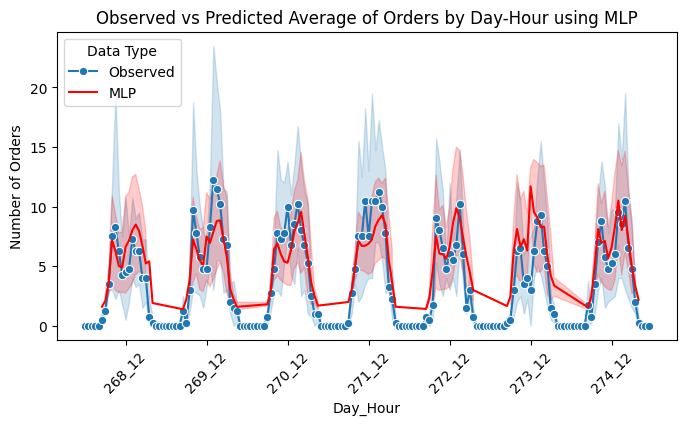

In [33]:
plot_test_prediction(padded_data,predicted_data_mlp,test_days,'MLP')

12/12 [==============================] - 2s 15ms/step


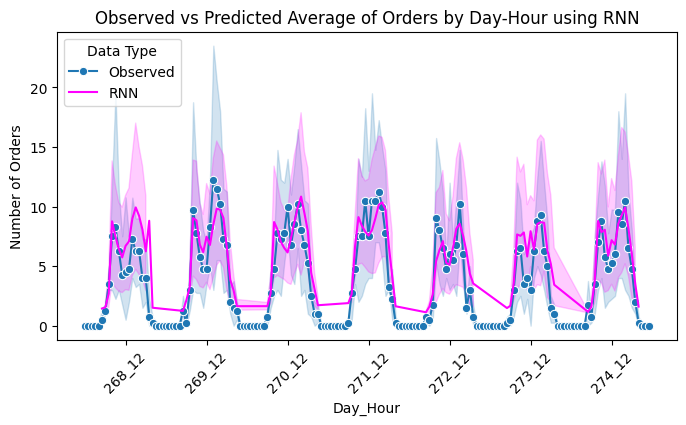

In [34]:
y_pred_rnn = rnn_model.predict(X_RNN_test_scaled).flatten()
predicted_data_rnn = get_test_pred_df(test_set, y_pred_rnn)
plot_test_prediction(padded_data,predicted_data_rnn,test_days,'RNN')

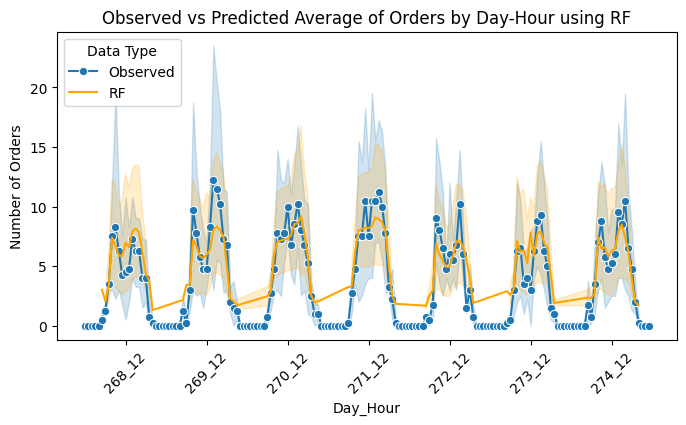

In [35]:
predicted_data_rf = get_test_pred_df(test_set, y_pred_rf)
plot_test_prediction(padded_data,predicted_data_rf,test_days,'RF')

## K-NN

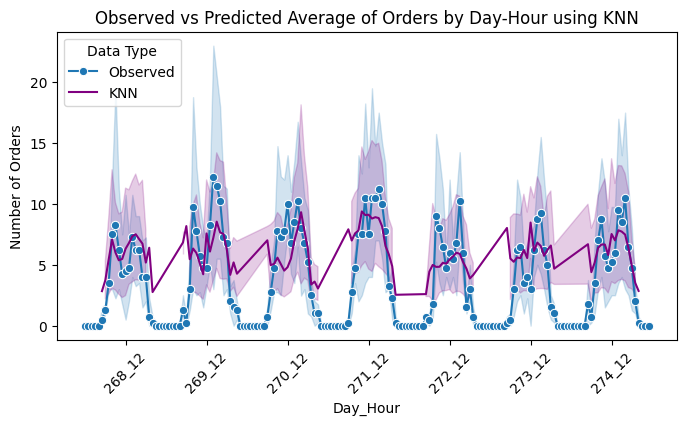

In [36]:
predicted_data_knn = get_test_pred_df(test_set, y_pred_knn)
plot_test_prediction(padded_data,predicted_data_knn,test_days,'KNN')

## XGBoost

In [37]:
mean_absolute_error(y_pred_xgb,y_test)

2.0782277351245284

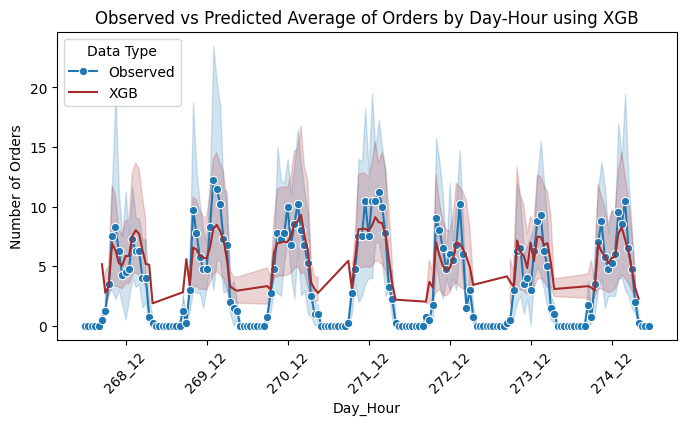

In [38]:
predicted_data_xgb = get_test_pred_df(test_set, y_pred_xgb)
plot_test_prediction(padded_data,predicted_data_xgb,test_days,'XGB')

## Predicted orders

Following scatter plot shows observed and predicted (Random Forest and XGB) numbers of orders in the test data.

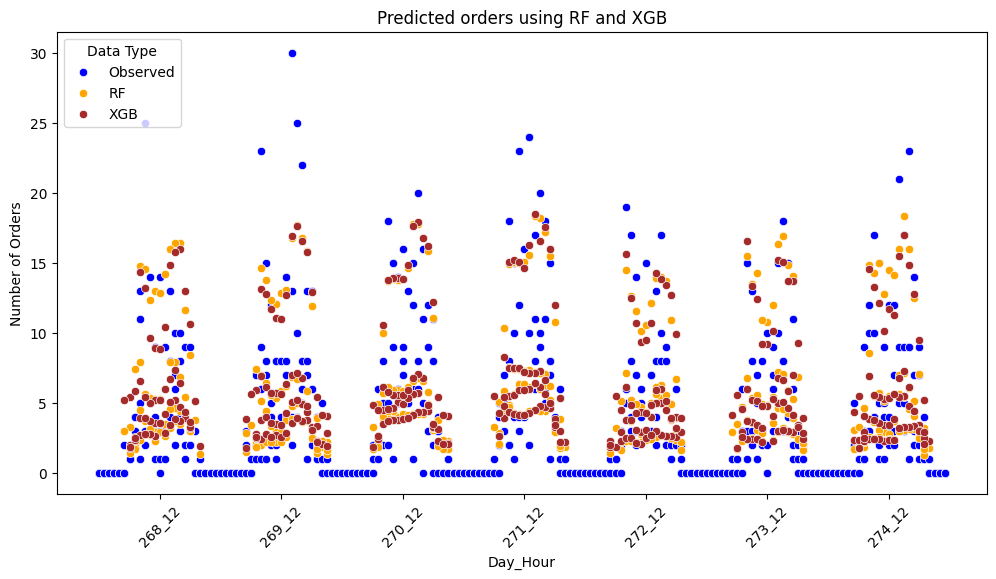

In [40]:
plot_test_scatter(padded_data,predicted_data_rf,predicted_data_xgb,test_days)

# Final conclusions

We are able to __accuratelly predict__ number of orders in different parts of Helsinki based on the hour of the day, day of the week and weather forecast. The average error is described by the mean absolute error of __Random Forest__ (the best performing algorithm) and it is around __1.96 orders__.

Below, we discuss each models performance/shortcomings/possible improvements.

- MLP is a first choice to tackle the time series problem. Its beauty is in the simplicity and  possible expressibility. The downside of this approach is that simple fully-dense NN does not understand the evolutionary side of the problem. It solves it as a simple regression problem. 
- K-Nearest Neighbours is not traditionally a time-series analysis model, but we used it for benchmarking purposes. Its performance on test data is the worst. It could be due to dimensionality and sparsity of this problem. The weather data is really sparse. But maybe crafting better representation of our data, we would be able to achieve better performance.
- LS-TM achieved better results than MLP, which is expected, but needless to say not by far. Having that many parameters, it was destined to predict the number of orders with high precision. Unfortunately, the chosen architecture was not a good fit for this problem.
- XGBoost: we start seeing very promising results as we can recreate the average number of orders during the day for different locations and days of the week well. The idea of using many week-learners and boost on them in the functional space, is very powerful and is paying off well in our case.

- Random Forest is able to split the feature space and predict the number of orders the best out of all the algorithms. It is able to accurately learn underlying patterns from data and predict with the highest accuracy on test data. It is also reliably learning the bimodal type of the desired orders’ distribution (peaks before lunch and before dinner). Also the final predictions have higher variance, which is in line with higher variance in observed data.


# Further Development

### Using different models

What would be of paramount desire is interpretability of models' parameters. This is almost never possible when Neural Networks are used. A promising way would be defining this problem as a Stochastic process (event happens = someone orders). It could be modeled by Neural ODEs (Neural Networks that are trained based on differences and not actual evaluations of functions) or Gaussian Processes. Gaussian Process would be very computationally heavy, as it is not paralelizable. But we can easily utilize the natural prior we have: The distribution of Orders should be bimodal (having two peaks) and they should be around lunch and dinner times.
- Need full access to data and perfect domain knowledge to model such complex processes
- e.g. Neural ODE or Gaussian Processes with bimodal prior (computationally heavy)

### Missing Data
What would increase the performance of the model would be also data that was lost in the preprocessing, i.e. missing data. We could have handled the missingness with a different approach that would incorporate information from partially observed data that was deleted in the beginning
Possible fix: 
- multiple imputation,
- stochastic regression on using observed variables (introduces bias)

Also, we have data only about orders, it would be beneficial to preprocess data to contain information about times when there are no orders too (e.g. collect weather data).

### Encoding of Latitude, Longitude

Improve encoding of location features. Currently one-hot  variable created by K-means used in NN prevents from maximum performance. We could have used some more insights about districts of Helsinki or use user locations as features too. 
- Quality representation/encoding may result in better performance
- e.g. One-hot encoding, embedding layers in NNs or use of domain knowledge